In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1

# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed face and background images
train_faces, train_face_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/faces/train/")
train_backgrounds, train_background_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/backgrounds/train/")

val_faces, val_face_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/faces/validation/")
val_backgrounds, val_background_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/backgrounds/validation/")

# Function to create EfficientNetB0
def create_efficientnet_b0(input_shape):
    efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Function to create EfficientNetB1
def create_efficientnet_b1(input_shape):
    efficientnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Create two-stream MLP model with EfficientNet as a feature extractor
def create_two_stream_mlp(input_shape):
    # Stream 1 for faces
    input_face = layers.Input(shape=input_shape, name='input_face')
    efficientnet_face = create_efficientnet_b0(input_shape)(input_face)
    flatten_face = layers.Flatten()(efficientnet_face)
    dense_face1 = layers.Dense(256, activation='relu')(flatten_face)
    dense_face2 = layers.Dense(128, activation='relu')(dense_face1)

    # Stream 2 for backgrounds
    input_background = layers.Input(shape=input_shape, name='input_background')
    efficientnet_background = create_efficientnet_b1((224, 224, 3))(input_background)
    flatten_background = layers.Flatten()(efficientnet_background)
    dense_background1 = layers.Dense(256, activation='relu')(flatten_background)
    dense_background2 = layers.Dense(128, activation='relu')(dense_background1)

    # Concatenate the two streams
    merged = layers.Concatenate()([dense_face2, dense_background2])

    # Common MLP layers
    common_dense1 = layers.Dense(128, activation='relu')(merged)
    common_dense2 = layers.Dense(64, activation='relu')(common_dense1)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(common_dense2)

    model = models.Model(inputs=[input_face, input_background], outputs=output_layer)
    return model

# Hyperparameters
input_shape = (224, 224, 3)
num_classes = 7  # Assuming each class has a directory

# Create two-stream MLP model
model = create_two_stream_mlp(input_shape)

# Compile the model
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['accuracy'])

# Convert labels to one-hot encoding
train_face_labels_one_hot = to_categorical(train_face_labels, num_classes=num_classes)
train_background_labels_one_hot = to_categorical(train_background_labels, num_classes=num_classes)

val_face_labels_one_hot = to_categorical(val_face_labels, num_classes=num_classes)
val_background_labels_one_hot = to_categorical(val_background_labels, num_classes=num_classes)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

batch_size = 32
# Apply data augmentation to the training set
train_datagen = datagen.flow([train_faces, train_backgrounds], train_face_labels_one_hot, batch_size=batch_size)

# ModelCheckpoint callback to save the model on every epoch
checkpoint_filepath = '/content/drive/MyDrive/caers/model_checkpoints/effnet_two_stream/best_model.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

# Train the model with data augmentation and save on every epoch
model.fit(train_datagen, epochs=50, validation_data=([val_faces, val_backgrounds], val_face_labels_one_hot), callbacks=[model_checkpoint_callback])

27018416/27018416 [==============================] - 2s 0us/step
Epoch 1/50
43/43 [==============================] - 326s 6s/step - loss: 1.2538 - accuracy: 0.5867 - val_loss: 1.4818 - val_accuracy: 0.5485
Epoch 2/50
43/43 [==============================] - 274s 6s/step - loss: 0.5526 - accuracy: 0.8469 - val_loss: 1.8765 - val_accuracy: 0.6667
Epoch 3/50
43/43 [==============================] - 256s 6s/step - loss: 0.3745 - accuracy: 0.9001 - val_loss: 1.6109 - val_accuracy: 0.6879
Epoch 4/50
43/43 [==============================] - 273s 6s/step - loss: 0.2754 - accuracy: 0.9155 - val_loss: 2.3660 - val_accuracy: 0.6409
Epoch 5/50
43/43 [==============================] - 257s 6s/step - loss: 0.2478 - accuracy: 0.9402 - val_loss: 1.3715 - val_accuracy: 0.7561
Epoch 6/50
43/43 [==============================] - 256s 6s/step - loss: 0.2267 - accuracy: 0.9359 - val_loss: 2.5668 - val_accuracy: 0.6530
Epoch 7/50
43/43 [==============================] - 266s 6s/step - loss: 0.2134 - accurac

1/1 [==============================] - 0s 97ms/step
660
660
[[0.80555556 0.         0.01111111 0.03061224 0.01960784 0.01052632
  0.02197802]
 [0.12962963 0.96052632 0.02222222 0.03061224 0.01960784 0.01052632
  0.        ]
 [0.         0.         0.83333333 0.02040816 0.04901961 0.
  0.14285714]
 [0.00925926 0.01315789 0.01111111 0.89795918 0.00980392 0.
  0.        ]
 [0.01851852 0.01315789 0.01111111 0.01020408 0.80392157 0.06315789
  0.03296703]
 [0.01851852 0.01315789 0.04444444 0.01020408 0.01960784 0.87368421
  0.01098901]
 [0.01851852 0.         0.06666667 0.         0.07843137 0.04210526
  0.79120879]]


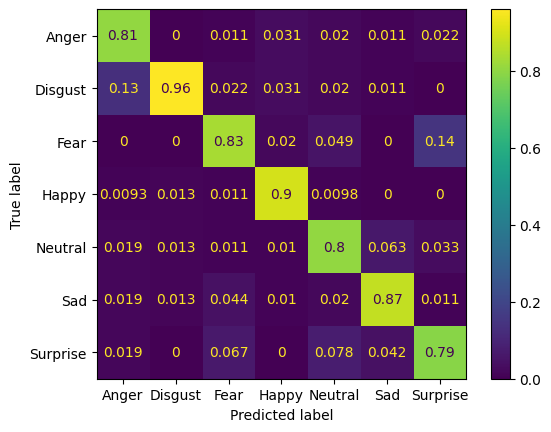

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1
from keras.models import load_model

y_pred = []  # store predicted labels
y_true = []  # store true labels

def create_efficientnet_b0(input_shape):
    efficientnet = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Function to create EfficientNetB1
def create_efficientnet_b1(input_shape):
    efficientnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    return efficientnet

# Create two-stream MLP model with EfficientNet as a feature extractor
def create_two_stream_mlp(input_shape):
    # Stream 1 for faces
    input_face = layers.Input(shape=input_shape, name='input_face')
    efficientnet_face = create_efficientnet_b0(input_shape)(input_face)
    flatten_face = layers.Flatten()(efficientnet_face)
    dense_face1 = layers.Dense(256, activation='relu')(flatten_face)
    dense_face2 = layers.Dense(128, activation='relu')(dense_face1)

    # Stream 2 for backgrounds
    input_background = layers.Input(shape=input_shape, name='input_background')
    efficientnet_background = create_efficientnet_b1((224, 224, 3))(input_background)
    flatten_background = layers.Flatten()(efficientnet_background)
    dense_background1 = layers.Dense(256, activation='relu')(flatten_background)
    dense_background2 = layers.Dense(128, activation='relu')(dense_background1)

    # Concatenate the two streams
    merged = layers.Concatenate()([dense_face2, dense_background2])

    # Common MLP layers
    common_dense1 = layers.Dense(128, activation='relu')(merged)
    common_dense2 = layers.Dense(64, activation='relu')(common_dense1)

    # Output layer
    output_layer = layers.Dense(num_classes, activation='softmax')(common_dense2)

    model = models.Model(inputs=[input_face, input_background], outputs=output_layer)
    return model


# Function to load images from a directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_path = os.path.join(directory, class_name)
        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            images.append(image_array)
            labels.append(label)
    return np.array(images), np.array(labels)

input_shape = (224, 224, 3)
num_classes = 7  # Assuming each class has a directory

train_faces, train_face_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/faces/train/")
train_backgrounds, train_background_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/backgrounds/train/")

val_faces, val_face_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/faces/validation/")
val_backgrounds, val_background_labels = load_images_from_directory("/content/drive/MyDrive/caers/modifed/backgrounds/validation/")

train_face_labels_one_hot = to_categorical(train_face_labels, num_classes=num_classes)
train_background_labels_one_hot = to_categorical(train_background_labels, num_classes=num_classes)

val_face_labels_one_hot = to_categorical(val_face_labels, num_classes=num_classes)
val_background_labels_one_hot = to_categorical(val_background_labels, num_classes=num_classes)

# Create two-stream MLP model
model = create_two_stream_mlp(input_shape)

model.load_weights('/content/drive/MyDrive/caers/model_checkpoints/effnet_two_stream/best_model.h5')

# iterate over the dataset
for val_face, val_background, label in zip(val_faces, val_backgrounds, val_face_labels_one_hot):
    val_face = np.reshape(val_face, (-1, 224, 224, 3))
    val_background = np.reshape(val_background, (-1, 224, 224, 3))

    # append true labels # Use extend instead of append

    # compute predictions
    preds = model.predict([val_face, val_background])

    # append predicted labels
    y_true.extend([np.argmax(label, axis=-1)] * len(val_face))
    y_pred.extend(np.argmax(preds, axis=-1).tolist())  # Use extend instead of append

# convert the true and predicted labels into tensors
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)
print(len(y_true_np))
print(len(y_pred_np))

from sklearn.metrics import confusion_matrix
result = confusion_matrix(y_true_np, y_pred_np, normalize='pred')
print(result)

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_display = ConfusionMatrixDisplay(confusion_matrix=result, display_labels=['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

cm_display.plot()
plt.show()